In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from utilities.data_downloader import train_val_test_downloader, choose_one_column
from utilities.plots import plt

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

In [5]:
random.seed(42)
np.random.seed(42)

# Description

### Features
We study two feature collections:
- **FeatureExtractor**--induced features (see dataset/README.md for a detailed discussion). These are tabular data by construction, hence the use of tree ensembles is well-motivated
- Rebinned and padded **countrate lightcurves**  identified with pseudo-tabular features

### IsolationForest
Independently from the kind of dataset, **IsolationForest** is utilized as follows:
1. The data are preprocessed by median-based **SimpleImputer** and **RobustScaler**. Importantly for the anomaly detection, both are robust to outliers.
2. Next, the **IsolationForest** anomalous scores are identified with the desired anomalous scores. To deal with a quantitative criterion, we compute ROC_AUC between these scores and the flag denoting whether and the flag denoting if there any X-Ray flares detected by *Swift*-XRT semi-manual analysis.
3. The **IsolationForest** parameter `n_estimators` is tuned with **GridSearchCV** to maximize the cross-validation-average of the ROC_AUC on the training set.
4. We finally study the best found estimator scores.

Note that there are no compact number of features produced by this algorithm despite the score itself. So there is no need in any additional visualization.

### Other
To make the results more interpretable, we also display the 10 most-anomalous-scored GRBs.

# Analysis Pipeline

In [6]:
def roc_auc_scoring(estimator, X, y)->float:
    yscore = -estimator.score_samples(X) # anomalous samples have smaller log-likelihood
    ytrue = y
    return roc_auc_score(ytrue, yscore)

In [7]:
def make_pipe(n_estimators:tuple):
    """
    Makes GridSearchCV pipeline
    """
    return Pipeline(
        [('imputer', SimpleImputer(
            missing_values=np.nan, strategy='median')),
         ('scaler', RobustScaler()),
         ('model', GridSearchCV(
             IsolationForest(random_state=42),
             param_grid={
                 'n_estimators': n_estimators},
             scoring=roc_auc_scoring, cv=2),
         ),
        ]
    )

In [8]:
def transform_dataset(pipe:Pipeline,
                      train:pd.DataFrame,
                      val:pd.DataFrame,
                      test:pd.DataFrame,
                      labels:pd.DataFrame)->pd.DataFrame:
    """
    Creates a joint dataframe of transformed features.
    """
    train_df, val_df, test_df = [
        pd.DataFrame(data=pipe.score_samples(df).reshape(-1, 1),
                     index=df.index, columns=['score']) for df in (train, val, test)
    ]
    train_df['sample'] = 'train'
    val_df['sample'] = 'val'
    test_df['sample'] = 'test'
    df = pd.concat((train_df, val_df, test_df), axis=0, ignore_index=False)
    df = pd.concat((df, labels), axis=1, ignore_index=False)
    return df

# Extracted Features Analysis

In [9]:
train, val, test, labels = train_val_test_downloader('features')
ytrain, yval, ytest = (
    labels.loc[train.index, 'FlaresFlag'],
    labels.loc[val.index, 'FlaresFlag'],
    labels.loc[test.index, 'FlaresFlag']
)

Datasets downloaded
 - train  : 810 entries
 - val    : 174 entries
 - test   : 174 entries
 - labels : 1158 entries


In [10]:
pipe = make_pipe(n_estimators=(10, 30, 100, 300))
pipe.fit(train, ytrain)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('model',
                 GridSearchCV(cv=2, estimator=IsolationForest(random_state=42),
                              param_grid={'n_estimators': (10, 30, 100, 300)},
                              scoring=<function roc_auc_scoring at 0x169e1b6a0>))])

In [11]:
# Flares detection best score
pipe._final_estimator.best_score_

0.5840963528805392

In [12]:
# Optimal parameters
pipe._final_estimator.best_params_

{'n_estimators': 100}

In [13]:
print('ROC-AUC Score:\n'+
      f'    train : {round(roc_auc_scoring(pipe, train, ytrain), 2)}\n'+
      f'    val   : {round(roc_auc_scoring(pipe, val, yval), 2)}\n'+
      f'    test  : {round(roc_auc_scoring(pipe, test, ytest), 2)}'
     )

ROC-AUC Score:
    train : 0.54
    val   : 0.57
    test  : 0.58


In [14]:
df = transform_dataset(pipe, train, val, test, labels)

In [15]:
# top-10 anomalous
df.sort_values(by='score', axis=0).head(10)

,score,sample,numbreaks,lc type,NH_gal,Redshift,Flares,FlaresFlag
GRB 200205A,-0.624617,train,1,One-break,0.4300,NaN,"[(210, 300), (2000, 20000.0), (80000.0, 400000...",1
GRB 150818A,-0.620957,train,2,Oddball,0.0247,NaN,"[(74.9, 84.1)]",1
GRB 100316D,-0.614417,train,1,One-break,0.1000,0.0590,[],0
GRB 050422,-0.598477,test,0,No breaks,1.1000,NaN,[],0
GRB 130427A,-0.582182,train,5,Oddball,0.0191,0.3400,"[(226, 272)]",1
GRB 060218,-0.581853,train,2,Oddball,0.1400,0.0331,"[(272, 292), (293, 6665)]",1
GRB 221009A,-0.581268,test,4,Canonical,0.5400,0.1510,"[(55599.99999999999, 73100.0), (73500.0, 89400...",1
GRB 090404,-0.575216,train,3,Canonical,0.0220,3.0000,"[(107, 144)]",1
GRB 060729,-0.562570,train,5,Canonical,0.0540,0.5400,"[(130, 146), (166, 225)]",1
GRB 200901B,-0.559628,train,2,Oddball,0.1200,NaN,[],0


Despite the fact that some anomalies are detected (e.g. GRB 221009A), the FeatureExtractor-based model **fails in capturing the important morphological patterns** (X-Ray flares).

# Rebinned Lightcurves Analysis (Padded LCs)

In [16]:
train, val, test, labels = train_val_test_downloader('padded')
train, val, test = tuple(
    map(lambda df: choose_one_column(df, 'lgRate'),
    (train, val, test))
)
ytrain, yval, ytest = (
    labels.loc[train.index, 'FlaresFlag'],
    labels.loc[val.index, 'FlaresFlag'],
    labels.loc[test.index, 'FlaresFlag']
)

Datasets downloaded
 - train  : 810 entries
 - val    : 174 entries
 - test   : 174 entries
 - labels : 1158 entries


In [17]:
pipe = make_pipe(n_estimators=(10, 30, 100, 300))
pipe.fit(train, ytrain)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('model',
                 GridSearchCV(cv=2, estimator=IsolationForest(random_state=42),
                              param_grid={'n_estimators': (10, 30, 100, 300)},
                              scoring=<function roc_auc_scoring at 0x169e1b6a0>))])

In [18]:
# Flares detection best score
pipe._final_estimator.best_score_

0.6744779860004085

In [19]:
# Optimal parameters
pipe._final_estimator.best_params_

{'n_estimators': 30}

In [20]:
print('ROC-AUC Score:\n'+
      f'    train : {round(roc_auc_scoring(pipe, train, ytrain), 2)}\n'+
      f'    val   : {round(roc_auc_scoring(pipe, val, yval), 2)}\n'+
      f'    test  : {round(roc_auc_scoring(pipe, test, ytest), 2)}'
     )

ROC-AUC Score:
    train : 0.66
    val   : 0.64
    test  : 0.66


In [21]:
df = transform_dataset(pipe, train, val, test, labels)

In [22]:
# top-10 anomalous
df.sort_values(by='score', axis=0).head(10)

,score,sample,numbreaks,lc type,NH_gal,Redshift,Flares,FlaresFlag
GRB 221009A,-0.755337,test,4,Canonical,0.5400,0.1510,"[(55599.99999999999, 73100.0), (73500.0, 89400...",1
GRB 130427A,-0.754768,train,5,Oddball,0.0191,0.3400,"[(226, 272)]",1
GRB 180728A,-0.732203,train,5,Oddball,0.3200,0.1170,[],0
GRB 130925A,-0.717242,test,5,Canonical,0.0175,0.3470,"[(0.0, 150), (450, 1179), (1250, 16000.0)]",1
GRB 180720B,-0.709749,val,4,Canonical,0.0392,0.6540,"[(81.8, 147), (438, 524), (540, 553), (563, 599)]",1
GRB 190829A,-0.709590,train,3,Oddball,0.0560,0.0785,"[(87.3, 180), (976, 10700.0)]",1
GRB 161219B,-0.702985,train,4,Canonical,0.0306,0.1475,"[(325, 697)]",1
GRB 130702A,-0.699653,train,1,One-break,0.0183,0.1450,[],0
GRB 060729,-0.694969,train,5,Canonical,0.0540,0.5400,"[(130, 146), (166, 225)]",1
GRB 150206A,-0.670116,val,1,One-break,0.0226,2.0870,"[(2044, 3500)]",1


The rebinned-lightcurve based model has better metrics, but **tends to overfit**: the most anomalous GRBs are the especially close ones (see redshift distribution below).  

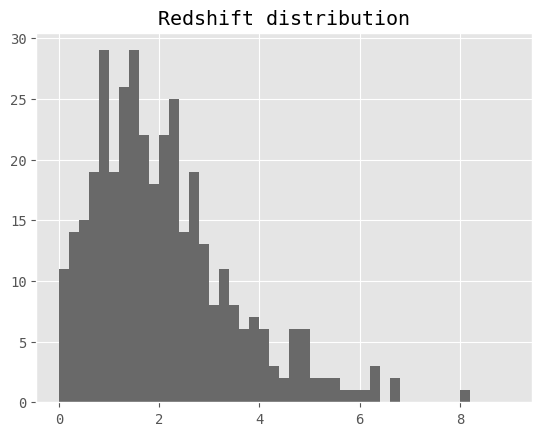

In [23]:
labels['Redshift'].dropna().hist(bins=np.linspace(0, 9, 46), color='dimgrey')
plt.title('Redshift distribution')
plt.show()